# Synthetic Poisson-distributed count data

We generate a set of intervals containing counts distributed according to: 

\begin{equation}
P(N=n \, | \, l, x) = \frac{F^n e^{-F}}{n!}, 
\end{equation}

where the rate is $F = lf(x)$ and $l$ is interval length, $x$ is some feature, and $f$ is a function that we will vary. [We sample $l$ and $x$ from uniform distributions.]

In [1]:
from synthetic_data import generate_counts
import numpy as np 

xs_max = 1
f = lambda x: np.exp(0.1 + 0.2*x) # monotonic rate function, f(x)

data_df = generate_counts(f, xs_max=xs_max)
data_df.head()

,counts,length,x
0,65.0,45.0,0.86
1,61.0,48.0,0.73
2,74.0,65.0,0.27
3,69.0,68.0,0.13
4,84.0,68.0,0.06


# Modeling the true rate $f(x)$

We now pretend that we don't know how the given data were generated. We assume that they were generated by a Poisson process with an average count function $H_\theta(l, x) = lh_\theta(x)$, where $\theta$ is a  parameter vector that dictates the form of the function. The goal is to choose $\theta$ to make  $h_\theta(x)$ match the true rate $f(x)$ in a sense that I make precise later on.

I will represent $h_\theta(x)$ by a neural network, since [neural networks can represent any function](http://neuralnetworksanddeeplearning.com/chap4.html). In the spirit of choosing the simplest model possible, I will consider the special case of [Poisson Regression](https://en.wikipedia.org/wiki/Poisson_regression), which can be viewed as a neural network that has no hidden layers and an activation function (called an inverse link function in the generalized-linear-model literature) equal to: 

\begin{equation}
h_\theta(x) =  e^{b + Wx} ,
\end{equation}

where $\theta = (b, W)$. The exponential guarantees that the rate is non-negative, as it must be. 

Setting up the Poisson regression code as a special case of a neural network affords us the opportunity to easily expand the analysis later on should we find that Poisson regression suffers from "high bias", i.e. the function $h_\theta(x)=  e^{b + Wx}$ is too simple. 



# Cost function

We reconstruct the true mutation rate $f(x)$ by maximizing the likelihood that our statistical model--a Poisson process with rate $h_\theta(x)$--would have produced the observed data. 
That likelihood is: 

\begin{equation}
P(N_1=n_1, \ldots, N_m = n_m \, | \,  L_1 = l_1, \ldots, L_m = l_m; X_1=x_1,\ldots,X_m=x_m; \theta) = \prod_{i=1}^m 
\frac{H_i(\theta)^{n_i} e^{-H_i(\theta)}} 
{n_i!},
\end{equation}

where 

\begin{equation}
H_i(\theta) = l_i h_\theta(x_i).
\end{equation} 



Maximizing the likelihood is the same as minimizing the negative log-likelihood. Scaling the latter by the number of data points $m$, we arrive at the following cost (objective) function: 

\begin{equation}
{\cal L}(\theta \, | \, x_1, \ldots, x_m; l_1, \ldots, l_m; n_1, \ldots, n_m) = \frac{1}{m} \sum_{i=1}^m \left[ \, 
H_i(\theta) - n_i \log H_i(\theta) + \log \left( n_i! \right)
\, \right] ,
\end{equation}
where $H_i(\theta)$ is the "predicted" count for interval $i$ and $n_i$ is the "actual"  count. 

[Note: we could have dropped the $\theta$-independent term, $\log \left( n_i! \right)$, from ${\cal L}$ since we only want to find the location, $\theta$, that minimizes the function, not its  value at that location, ${\cal L(\theta)}$. Keeping the log-factorial term endows
${\cal L(\theta)}$ with the nice property that it can be no smaller than 0 since the likelihood can be no larger than 1.]

# Training the model

Here is the code for setting up the neural network and its cost function, and minimizing the cost function by varying the parameters $\theta$, i.e. "training" the model: 

In [2]:
import disable_pager
from model import train
train??

Signature: train(data_df, l_heading_list, X_heading_list, y_heading_list, number_hidden_nodes=1)
Source:   
def train(data_df, l_heading_list, X_heading_list, y_heading_list, number_hidden_nodes=1):
    # turn off tensorflow warning messages
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

    tf.reset_default_graph()

    tf.set_random_seed(1)

    sample_size = len(data_df)

    number_exposure_input_nodes = len(l_heading_list)
    number_feature_input_nodes = len(X_heading_list)
    number_output_nodes = len(y_heading_list)

    # exposure input to neural network
    with tf.variable_scope('exposure_input_layer'):
        l = tf.placeholder(tf.float32, shape=(sample_size, number_exposure_input_nodes))

    # feature inputs to neural network
    with tf.variable_scope('feature_input_layer'):
        X = tf.placeholder(tf.float32, shape=(sample_size, number_feature_input_nodes))

    # # hidden layer (placeholder for later development beyond Poisson regression)
    # with tf.variable_sco

# Comparison of data generation schemes

Hover over the data points in the plotly graphs below to see the feature values that correspond to each data point...

## Monotonic rate function

Instructions for updating:
Use the retry module or similar alternatives.


,epoch,cost,likelihood,bias,weight
0,0,18.19,0.0,[0.1],[[-0.9544517]]
1,10,6.93,0.0,[0.6021365],[[-0.26071644]]
2,20,4.36,0.0,[0.19472076],[[-0.25219253]]
3,30,3.48,0.0,[0.21994278],[[0.11757414]]
4,40,3.33,0.0,[0.076359004],[[0.19030899]]
5,50,3.33,0.0,[0.07340542],[[0.28602317]]
6,60,3.33,0.0,[0.051581454],[[0.27266094]]
7,70,3.32,0.0,[0.07584149],[[0.26776823]]
8,80,3.32,0.0,[0.07721285],[[0.23633513]]
9,90,3.32,0.0,[0.090980664],[[0.23274124]]


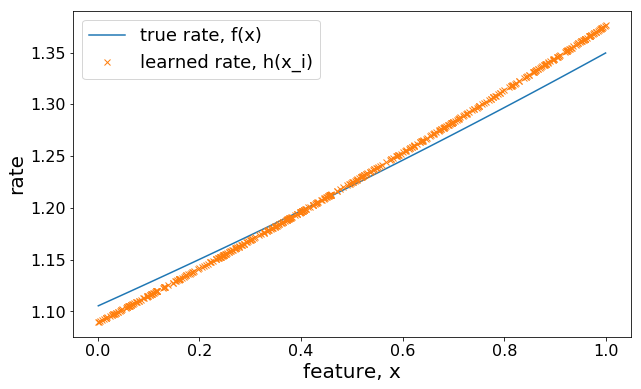

In [3]:
# using plt.show() in plot_rates instead of magic command doesn't display figures!
%matplotlib inline 

from analyze import analyze 
import numpy as np 

xs_max = 1
f = lambda x: np.exp(0.1 + 0.2*x) # monotonic rate function, f(x)

data_df, log_df = analyze(f=f, xs_max=xs_max)

log_df

## Non-monotonic rate function

Poisson regression assumes that the dependence of the rate on the feature variable is monotonic:

\begin{equation}
h_\theta(x) =  e^{b + Wx}.
\end{equation}

When this assumption is violated, e.g., when the true dependence is non-monotonic, Poisson regression performs poorly: 

,epoch,cost,likelihood,bias,weight
0,0,15.38,0.0,[-0.1],[[-1.1544517]]
1,10,4.49,0.0,[-0.9418348],[[-1.9197935]]
2,20,4.82,0.0,[-1.2765645],[[-1.9566892]]
3,30,4.17,0.0,[-1.2421181],[[-1.5350502]]
4,40,3.78,0.0,[-1.1731547],[[-1.0773747]]
5,50,3.64,0.0,[-1.2774096],[[-0.8399922]]
6,60,3.50,0.0,[-1.4435238],[[-0.7182907]]
7,70,3.44,0.0,[-1.5293865],[[-0.54900074]]
8,80,3.39,0.0,[-1.5723093],[[-0.3825953]]
9,90,3.38,0.0,[-1.6280817],[[-0.28852937]]


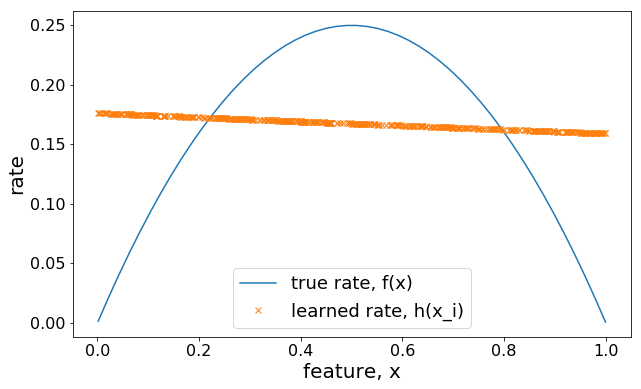

In [4]:
f = lambda x: x*(xs_max-x) # non-monotonic rate function, f(x)
data_df, log_df = analyze(f=f, xs_max=xs_max)
log_df

# Related work

Please see Chris Bishop's [excellent article](mixture_density_networks.pdf) describing mixture density networks, which are generalizations of what is described here. 